In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
import seaborn as sns
import arviz as az
from os.path import join, split, splitext
from toolz import pipe
from fetch_data import create_arrays

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Your Python environment has Theano(-PyMC) 1.1.2 installed, but you are importing PyMC 4.0.0b1 which uses Aesara as its backend.
For PyMC 4.0.0b1 to work as expected you should uninstall Theano(-PyMC).
See https://github.com/pymc-devs/pymc/wiki for update instructions.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
You are importing PyMC 4.0.0b1, but your environment also has the legacy version PyMC3 3.11.4 installed.
For PyMC 4.0.0b1 to work as expected you should uninstall PyMC3.
See https://github.com/pymc-devs/pymc/wiki for update instructions.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


In [16]:
# Directory containing model runs -- change as needed
run_dir = './pymc_vs_stan/rerun_20_12_2021///fits/'

# Directory to save plots in -- change as needed
plot_dir = './pymc_vs_stan/writeup/'

# Find all runtime files:
all_runtimes = glob(join(run_dir, '*/*.txt'))

In [17]:
len(all_runtimes)

40

In [18]:
# Extract runtimes from text files 
runtimes = [float(list(open(x))[0].strip()) for x in all_runtimes]

In [19]:
# Helper function to extract some more info from the filenames
def extract_info(filenames):
    
    approach_names = [x.split('/')[-2] for x in filenames]
    filenames = [split(splitext(x)[0])[-1] for x in filenames]
    years = [int(x.split('_')[-1]) for x in filenames]
    
    return {'year': years, 'method': approach_names}

In [20]:
info = extract_info(all_runtimes)
info['runtime'] = runtimes

In [21]:
results = pd.DataFrame(info)

In [22]:
results.sort_values('runtime')

,year,method,runtime
10,2020,cmdstanpy,7.368208
2,2020,pymc_jax_cpu_parallel,7.543173
26,2020,pymc_jax_gpu_parallel,7.619804
7,2019,pymc_jax_cpu_parallel,9.756483
31,2019,pymc_jax_gpu_parallel,9.758338
15,2019,cmdstanpy,11.610564
34,2020,pymc,14.100785
39,2019,pymc,19.254810
25,2015,pymc_jax_gpu_parallel,20.717813
1,2015,pymc_jax_cpu_parallel,20.720483


In [23]:
# Fetch the number of data points for each year from the dataset
of_interest = results['year'].unique()

data = {x: create_arrays(x)['winner_ids'].shape[0] for x in of_interest}

In [24]:
results['n_matches'] = [data[row.year] for row in results.itertuples()]

In [25]:
total_matches = results['n_matches'].max()

In [26]:
results['log_matches'] = np.log10(results['n_matches'])

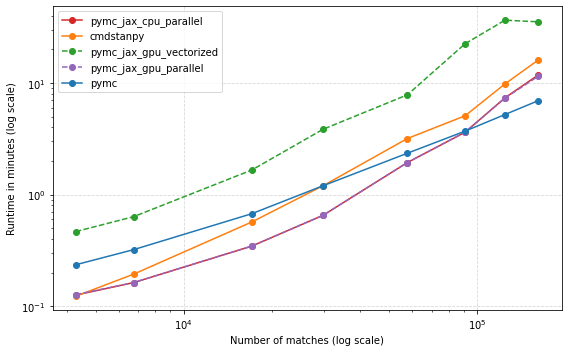

In [27]:
f, ax = plt.subplots(1, 1)

of_interest = ['pymc', 'cmdstanpy', 'pymc_jax_gpu_vectorized', 'pymc_jax_cpu_parallel', 'pymc_jax_gpu_parallel',]

colours = sns.color_palette(palette=None, n_colors=len(of_interest))

colour_lookup = {x: y for x, y in zip(of_interest, colours)}

rel_results = results[results['method'].isin(of_interest)]

for cur_method in rel_results['method'].unique():
    
    cur_data = rel_results[rel_results['method'] == cur_method].sort_values('n_matches')
    
    linestyle = '--' if 'gpu' in cur_method else None
    
    ax.plot(cur_data['n_matches'], cur_data['runtime'] / 60, label=cur_method, marker='o', linestyle=linestyle,
            color=colour_lookup[cur_method])
    
ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlabel('Number of matches (log scale)')
ax.set_ylabel('Runtime in minutes (log scale)')

ax.grid(alpha=0.5, linestyle='--')

ax.legend()

f.set_size_inches(8, 5)
f.tight_layout()

plt.savefig(join(plot_dir, 'walltime_plot.png'), dpi=300)

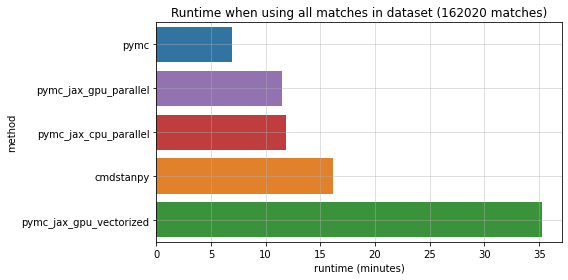

In [28]:
f, ax = plt.subplots(1, 1)

to_plot = rel_results[rel_results['n_matches'] == rel_results['n_matches'].max()].copy()

to_plot['runtime (minutes)'] = to_plot['runtime'] / 60

to_plot = to_plot.sort_values('runtime (minutes)')

colours_to_plot = [colour_lookup[x] for x in to_plot['method']]

sns.barplot(x=to_plot['runtime (minutes)'], y=to_plot['method'], ax=ax, palette=colours_to_plot)
ax.grid(alpha=0.5)

ax.set_title(f'Runtime when using all matches in dataset ({total_matches} matches)')

f.set_size_inches(8, 4)
f.tight_layout()

plt.savefig(join(plot_dir, 'walltime_full.png'), dpi=300)

In [29]:
to_plot = to_plot.set_index('method', drop=False)

to_plot['runtime'] / to_plot['runtime'].min()

method
pymc                       1.000000
pymc_jax_gpu_parallel      1.659046
pymc_jax_cpu_parallel      1.700775
cmdstanpy                  2.317711
pymc_jax_gpu_vectorized    5.077220
Name: runtime, dtype: float64

In [30]:
to_plot['runtime'] / 60

method
pymc                        6.950231
pymc_jax_gpu_parallel      11.530756
pymc_jax_cpu_parallel      11.820778
cmdstanpy                  16.108623
pymc_jax_gpu_vectorized    35.287849
Name: runtime, dtype: float64

In [31]:
# Compute ESS / second

In [32]:
all_draws = glob(join(run_dir, '*/*.netcdf'))

In [33]:
def compute_min_ess(arviz_draws):
    
    min_ess = az.ess(arviz_draws).min()
    
    return float(min_ess.to_array().min().values)

In [34]:
min_ess = list(pipe(all_draws,
               # Load
               lambda x: map(az.from_netcdf, x),
               # Compute minimum ESS
               lambda x: map(compute_min_ess, x)
              ))

In [35]:
draw_info = extract_info(all_draws)

In [36]:
ess_info = pd.DataFrame({'min_ess': min_ess, 'method': draw_info['method'], 'year': draw_info['year']})

In [37]:
with_runtime = ess_info.merge(results)

with_runtime['ESS / second'] = with_runtime['min_ess'] / with_runtime['runtime']

In [38]:
with_runtime.head()

,min_ess,method,year,runtime,n_matches,log_matches,ESS / second
0,565.286569,pymc_jax_cpu_parallel,2015,20.720483,17064,4.232081,27.281534
1,328.566944,pymc_jax_cpu_parallel,2000,116.107535,57877,4.762506,2.829850
2,466.413961,pymc_jax_cpu_parallel,2010,39.094711,29851,4.474959,11.930360
3,828.489113,pymc_jax_cpu_parallel,2019,9.756483,6745,3.828982,84.916781
4,559.851291,pymc_jax_cpu_parallel,1980,441.080843,124484,5.095114,1.269271


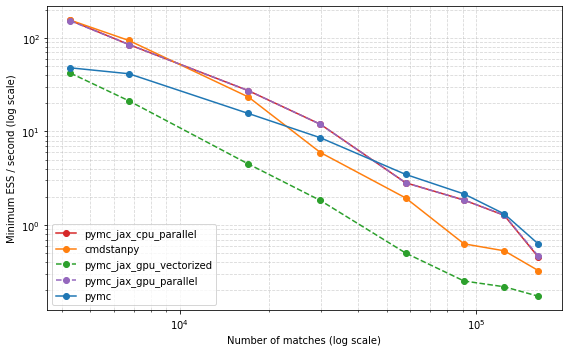

In [39]:
f, ax = plt.subplots(1, 1)

rel_results = with_runtime[with_runtime['method'].isin(of_interest)]

for cur_method in rel_results['method'].unique():
    
    cur_data = rel_results[rel_results['method'] == cur_method].sort_values('n_matches')
    
    linestyle = '--' if 'gpu' in cur_method else None
    
    ax.plot(cur_data['n_matches'], cur_data['ESS / second'], label=cur_method, marker='o', linestyle=linestyle,
            color=colour_lookup[cur_method])
    
ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlabel('Number of matches (log scale)')
ax.set_ylabel('Minimum ESS / second (log scale)')

ax.grid(alpha=0.5, linestyle='--', which='both')

ax.legend(loc='lower left')

f.set_size_inches(8, 5)
f.tight_layout()

plt.savefig(join(plot_dir, 'ess_values.png'), dpi=300)

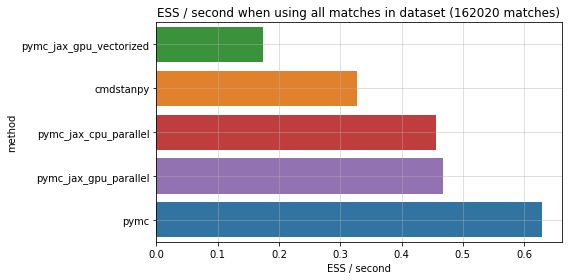

In [40]:
f, ax = plt.subplots(1, 1)

to_plot = rel_results[rel_results['year'] == 1968].sort_values('ESS / second')

colours_to_plot = [colour_lookup[x] for x in to_plot['method']]

sns.barplot(x=to_plot['ESS / second'], y=to_plot['method'], ax=ax, palette=colours_to_plot)

ax.grid(alpha=0.5)

ax.set_title(f'ESS / second when using all matches in dataset ({total_matches} matches)')

f.set_size_inches(8, 4)
f.tight_layout()

plt.savefig(join(plot_dir, 'ess_per_second_full.png'), dpi=300)

In [41]:
rel = to_plot.set_index('method', drop=False)

rel['ESS / second'].max() / rel['ESS / second']

method
pymc_jax_gpu_vectorized    3.622780
cmdstanpy                  1.926070
pymc_jax_cpu_parallel      1.381133
pymc_jax_gpu_parallel      1.347247
pymc                       1.000000
Name: ESS / second, dtype: float64

In [42]:
11.3 / 3.9

2.897435897435898

In [43]:
# Check estimates agree

stan_res = az.from_netcdf(join(run_dir, 'cmdstanpy/samples_1968.netcdf'))

In [44]:
list(stan_res.keys())

['posterior', 'sample_stats']

In [45]:
p_skills = stan_res.posterior['player_skills']

player_means_stan = p_skills.values.mean(axis=(0, 1))
player_sds_stan = p_skills.values.std(axis=(0, 1))

In [46]:
pymc3_res = az.from_netcdf(join(run_dir, 'pymc/samples_1968.netcdf'))

In [47]:
p_skills_pymc3 = pymc3_res.posterior['player_skills'].mean(dim=('chain', 'draw'))
p_skills_pymc3_sd = pymc3_res.posterior['player_skills'].std(dim=('chain', 'draw'))

In [48]:
# Load data for 1968 to get player names
cur_data = create_arrays(1968)

jax_res = az.from_netcdf(join(run_dir, 'pymc_jax_gpu_vectorized/samples_1968.netcdf'))

In [49]:
cur_data['player_encoder']

LabelEncoder()

In [50]:
p_skills_jax = jax_res.posterior['player_skills'].mean(dim=('chain', 'draw'))
p_skills_jax_sd = jax_res.posterior['player_skills'].std(dim=('chain', 'draw'))

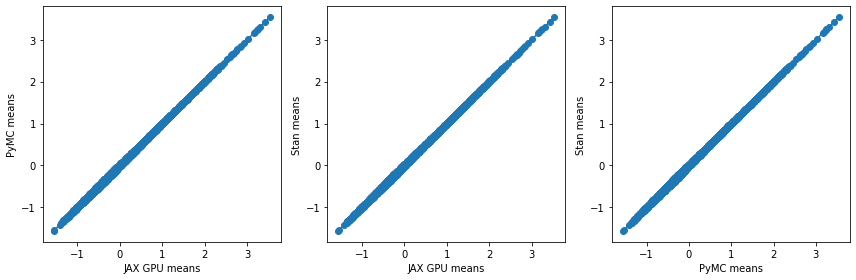

In [51]:
f, ax = plt.subplots(1, 3)

ax[0].scatter(p_skills_jax.values.reshape(-1), p_skills_pymc3.values.reshape(-1))
ax[0].plot([p_skills_jax.min(), p_skills_jax.max()], [p_skills_jax.min(), p_skills_jax.max()])

ax[1].scatter(p_skills_jax.values.reshape(-1), player_means_stan.reshape(-1))
ax[1].plot([p_skills_jax.min(), p_skills_jax.max()], [p_skills_jax.min(), p_skills_jax.max()])

ax[2].scatter(p_skills_pymc3.values.reshape(-1), player_means_stan.reshape(-1))
ax[2].plot([p_skills_pymc3.min(), p_skills_pymc3.max()], [p_skills_pymc3.min(), p_skills_pymc3.max()])

ax[0].set_xlabel('JAX GPU means')
ax[0].set_ylabel('PyMC means')

ax[1].set_xlabel('JAX GPU means')
ax[1].set_ylabel('Stan means')

ax[2].set_xlabel('PyMC means')
ax[2].set_ylabel('Stan means')

f.set_size_inches(12, 4)
f.tight_layout()

plt.savefig(join(plot_dir, 'mean_comparison.png'), dpi=300)

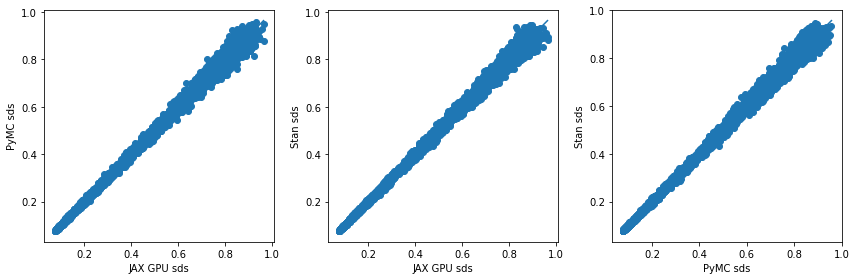

In [52]:
f, ax = plt.subplots(1, 3)

ax[0].scatter(p_skills_jax_sd.values.reshape(-1), p_skills_pymc3_sd.values.reshape(-1))
ax[0].plot([p_skills_jax_sd.min(), p_skills_jax_sd.max()], [p_skills_jax_sd.min(), p_skills_jax_sd.max()])

ax[1].scatter(p_skills_jax_sd.values.reshape(-1), player_sds_stan.reshape(-1))
ax[1].plot([p_skills_jax_sd.min(), p_skills_jax_sd.max()], [p_skills_jax_sd.min(), p_skills_jax_sd.max()])

ax[2].scatter(p_skills_pymc3_sd.values.reshape(-1), player_sds_stan.reshape(-1))
ax[2].plot([p_skills_pymc3_sd.min(), p_skills_pymc3_sd.max()], [p_skills_pymc3_sd.min(), p_skills_pymc3_sd.max()])

ax[0].set_xlabel('JAX GPU sds')
ax[0].set_ylabel('PyMC sds')

ax[1].set_xlabel('JAX GPU sds')
ax[1].set_ylabel('Stan sds')

ax[2].set_xlabel('PyMC sds')
ax[2].set_ylabel('Stan sds')

f.set_size_inches(12, 4)
f.tight_layout()

plt.savefig(join(plot_dir, 'sd_comparison.png'), dpi=300)

In [53]:
p_skills.shape

(4, 1000, 4825)

In [54]:
p_skills_jax.shape

(4825,)

In [55]:
print(pd.DataFrame({'mean_skill': p_skills_jax, 'skill_sd': p_skills_jax_sd}, index=cur_data['player_encoder'].classes_).sort_values('mean_skill', ascending=False).head(20).round(2).to_markdown())

ImportError: Missing optional dependency 'tabulate'.  Use pip or conda to install tabulate.